/tmp/ipykernel_426925/578364319.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_yticklabels(boxplot.get_yticklabels(), horizontalalignment='right')


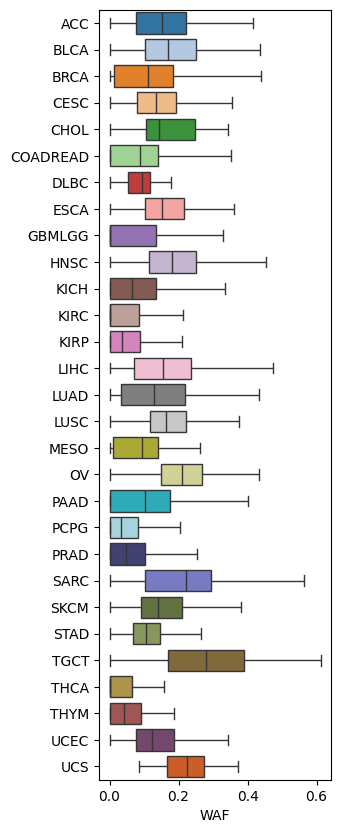

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_colors_dict, featre_to_tick
from statannotations.Annotator import Annotator

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancerNew_withAtypicalNew.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = ["aty_wsi_ratio",
              ]
df = discov_df [['type'] + feats_list]
df = discov_df[['type']+feats_list]
invalid_cancers = ['LAML','UVM']
df = df[~df['type'].isin(invalid_cancers)]

# change COAD and READ to COADREAD
df['type'] = df['type'].replace(['COAD','READ'], 'COADREAD')
df['type'] = df['type'].replace(['GBM','LGG'], 'GBMLGG')

df = df.sort_values(by="type")

color_pallete = get_colors_dict()
for feat in feats_list:
    plt.figure(figsize=(3, 10))
    boxplot = sns.boxplot(y='type', x=feat, hue='type', data=df, showfliers=False, palette=color_pallete)
    boxplot.set_yticklabels(boxplot.get_yticklabels(), horizontalalignment='right')
    boxplot.set_xlabel(featre_to_tick(feat))
    plt.legend([],[], frameon=False)
    boxplot.set_ylabel('')

    plt.show()


/tmp/ipykernel_2034422/3903213608.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


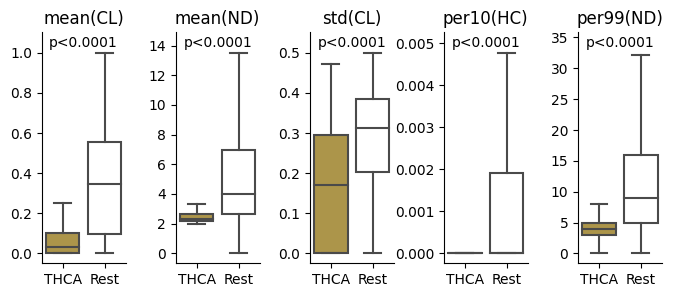

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from utils import get_colors_dict, featre_to_tick

# Loading the data
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer.csv'
discov_df = pd.read_csv(discov_val_feats_path)

desired_cancer_type = "THCA"
desired_features = [
                    "mean(CL)",
                    "mean(ND)",
                    "mit_clusterCoff_std",
                    "mit_cenHarmonic_per10",
                    "mit_nodeDegrees_per99",
                    ]

# Filter and process the data
df = discov_df[['type'] + desired_features]
invalid_cancers = ['UVM', 'LAML']
df = df[~df['type'].isin(invalid_cancers)]

# Change COAD and READ to COADREAD
df['type'] = df['type'].replace(['COAD', 'READ'], 'COADREAD')
df['type'] = df['type'].replace(['GBM', 'LGG'], 'COADREAD')

# Get the color dictionary
color_dict = get_colors_dict()

# Set the palette based on the category
palette = {
    desired_cancer_type: color_dict.get(desired_cancer_type, 'blue'),
    "Rest": color_dict.get("Rest", 'white')
}

# Create a figure with subplots
# fig, axes = plt.subplots(1, len(desired_features), figsize=(1.5 * len(desired_features), 3.5))
fig, axes = plt.subplots(1, len(desired_features), figsize=(1.6 * len(desired_features), 3), gridspec_kw={'wspace': 0.6})

for ax, feature in zip(axes, desired_features):
    # Prepare the data for plotting
    plot_data = []
    
    # Data for the desired cancer type
    desired_data = df[df['type'] == desired_cancer_type][feature]
    plot_data.extend([(desired_cancer_type, val) for val in desired_data])
    
    # Data for all Rest cancer types
    Rest_data = df[df['type'] != desired_cancer_type][feature]
    plot_data.extend([('Rest', val) for val in Rest_data])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Category', 'Value'])

    # Plotting without outlier dots
    sns.boxplot(x='Category', y='Value', data=plot_df, palette=palette, showfliers=False, ax=ax)

    # Perform statistical tests and annotate the plot
    desired_values = plot_df[plot_df['Category'] == desired_cancer_type]['Value']
    Rest_values = plot_df[plot_df['Category'] == 'Rest']['Value']
    
    # Perform Mann-Whitney U test
    p_value = mannwhitneyu(desired_values, Rest_values, alternative='two-sided').pvalue
    
    # Calculate position for text annotation
    Q1_desired = desired_values.quantile(0.25)
    Q3_desired = desired_values.quantile(0.75)
    IQR_desired = Q3_desired - Q1_desired
    max_whisker_desired = min(max(desired_values), Q3_desired + 1.5 * IQR_desired)

    Q1_Rest = Rest_values.quantile(0.25)
    Q3_Rest = Rest_values.quantile(0.75)
    IQR_Rest = Q3_Rest - Q1_Rest
    max_whisker_Rest = min(max(Rest_values), Q3_Rest + 1.5 * IQR_Rest)

    max_whisker = max(max_whisker_desired, max_whisker_Rest) * 1.05
    text_y = max_whisker# + 0.05 * max_whisker
    
    # Add annotation with white background
    if p_value > 0.0001:
        t = ax.text(0.5, text_y, f"p={p_value:.3f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
        t.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor=None))
    else:
        t= ax.text(0.5, text_y, f"p<0.0001", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
        t.set_bbox(dict(facecolor='white', alpha=0.0, edgecolor=None))
    
    # Draw line for significance
    # ax.plot([0, 1], [max_whisker] * 2, color='black', lw=1.5, marker='|')

    # Set the title of the subplot
    ax.set_title(f'{featre_to_tick(feature)}')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim([None, max_whisker*1.05])

    # Remove top and right box lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

save_dir = "results_final/landscape/domain_classification_one-vs-rest/"
plt.tight_layout()
plt.savefig(save_dir+f"top_feat_dist_{desired_cancer_type}.png", dpi=600, bbox_inches='tight')
# plt.show()


/tmp/ipykernel_3673019/2449402392.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticklabels(), horizontalalignment='right')
/tmp/ipykernel_3673019/2449402392.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='center')
/tmp/ipykernel_3673019/2449402392.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, ha='center')
/tmp/ipykernel_3673019/2449402392.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax3, y=feat, x='gender', data=df, showfliers=False, palette=gender_palette)
/tmp/ipykernel_3673019/2449402392.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  a

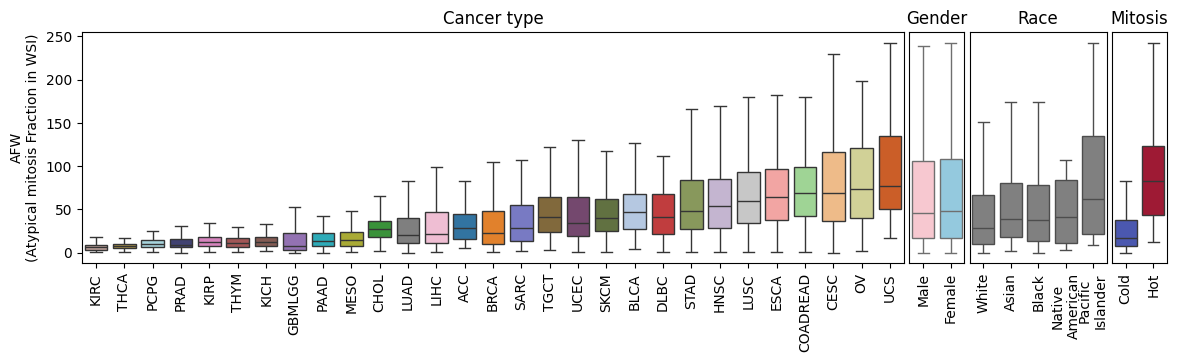

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import get_colors_dict, featre_to_tick

# Load the data
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer_withAtypical.csv'
discov_df = pd.read_csv(discov_val_feats_path)

# Load feature list
feats_list = ["HSC"] # aty_wsi_ratio, aty_ahotspot_count

# Filter the dataframe to include relevant columns and remove invalid cancers
df = discov_df[['type', 'temperature', 'gender', 'race'] + feats_list]
invalid_cancers = ['LAML', 'UVM']
df = df[~df['type'].isin(invalid_cancers)]

# Combine specific cancer types
df['type'] = df['type'].replace(['COAD', 'READ'], 'COADREAD')
df['type'] = df['type'].replace(['GBM', 'LGG'], 'GBMLGG')

# Filter the race column to keep only certain values and shorten the names
valid_races = ['WHITE', 'BLACK OR AFRICAN AMERICAN', 'ASIAN', 
               'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
               'AMERICAN INDIAN OR ALASKA NATIVE']

race_short_map = {
    'WHITE': 'White',
    'BLACK OR AFRICAN AMERICAN': 'Black',
    'ASIAN': 'Asian',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Pacific\nIslander',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'Native\nAmerican'
}

# Keep only the valid races and map to shorter names
df = df[df['race'].isin(valid_races)]
df['race'] = df['race'].map(race_short_map)

# Sort dataframe by 'type'
df = df.sort_values(by="type")

# Get color palette
color_pallete = get_colors_dict()

# Plot the data for each feature
for feat in feats_list:
    # Create a figure with four subplots (type, race, gender, temperature - swapped)
    fig, (ax1, ax3, ax4, ax2) = plt.subplots(1, 4, figsize=(14, 3), gridspec_kw={'width_ratios': [30, 2, 5, 2]})
    
    # Boxplot by type (left plot)
    # **Compute the mean of 'feat' for each 'type' and sort them**
    mean_feat_by_type = df.groupby('type')[feat].mean()
    sorted_types = mean_feat_by_type.sort_values().index.tolist()

    sns.boxplot(ax=ax1, y=feat, x='type', hue='type', data=df, showfliers=False, palette=color_pallete,
                order=sorted_types, hue_order=sorted_types)
    ax1.set_yticklabels(ax1.get_yticklabels(), horizontalalignment='right')
    # ax1.set_ylabel(featre_to_tick(feat))
    ax1.set_ylabel('AFW\n(Atypical mitosis Fraction in WSI)')
    ax1.set_xlabel('')
    ax1.set_title('Cancer type')
    ax1.legend([], [], frameon=False)  # Remove the legend for the type boxplot
    
    # Rotate x-axis ticks on the first plot
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='center')

    # Boxplot by race (now second plot)
    sns.boxplot(ax=ax4, y=feat, x='race', data=df, showfliers=False, color="gray")
    ax4.set_xlabel(featre_to_tick(feat))
    ax4.set_ylabel('')
    ax4.set_xlabel('')
    ax4.set_title('Race')
    
    # Remove y-axis ticks and labels for the second plot (race)
    ax4.set_yticklabels([])  # Remove y-axis labels
    ax4.tick_params(left=False, right=False)  # Remove y-axis ticks
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90, ha='center')

    # Boxplot by gender (third plot)
    gender_palette = {'MALE': 'skyblue', 'FEMALE': 'pink'}
    # Apply the custom color palette to the boxplot
    sns.boxplot(ax=ax3, y=feat, x='gender', data=df, showfliers=False, palette=gender_palette)
    ax3.set_xlabel(featre_to_tick(feat))
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.set_xticklabels(['Male', 'Female'], rotation=90, ha='center')
    ax3.set_title('Gender')
    
    # Remove y-axis ticks and labels for the third plot (gender)
    ax3.set_yticklabels([])  # Remove y-axis labels
    ax3.tick_params(left=False, right=False)  # Remove y-axis ticks
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, ha='center')

    # Boxplot by temperature (now fourth plot)
    cmap = plt.get_cmap('coolwarm')
    hot_cold_palette = {'Hot': cmap(.999), 'Cold': cmap(0)}
    sns.boxplot(ax=ax2, y=feat, x='temperature', data=df, showfliers=False, palette=hot_cold_palette)
    ax2.set_xlabel(featre_to_tick(feat))
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.set_title('Mitosis')
    
    # Remove y-axis ticks and labels for the fourth plot (temperature)
    ax2.set_yticklabels([])  # Remove y-axis labels
    ax2.tick_params(left=False, right=False)  # Remove y-axis ticks
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='center') # , rotation=45, ha='right'

    # Adjust layout to bring subplots closer
    plt.subplots_adjust(wspace=0.02)

    plt.savefig(f"results_final_all/morphology/dist_{feat}.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
    # plt.savefig(f"results_final_all/morphology/dist_{feat}.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
    # Adjust layout
    plt.show()


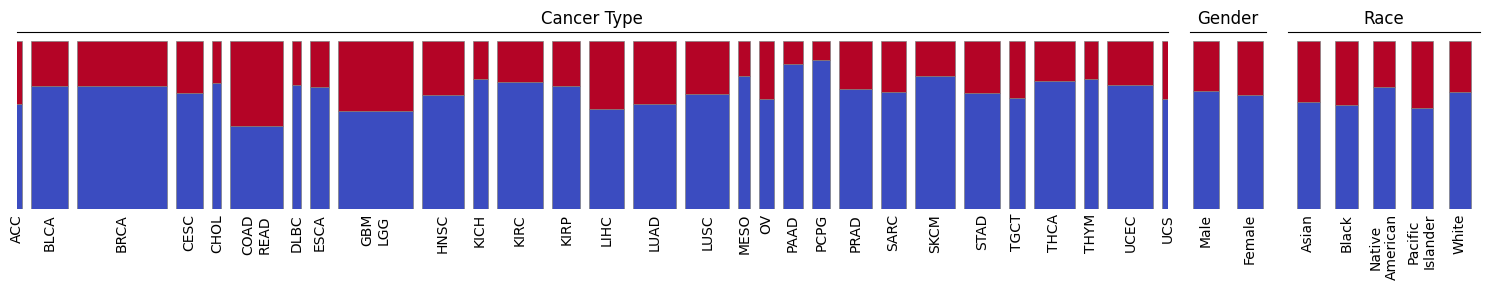

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer_withAtypical.csv')

ALL_CANCERS = ['LIHC', 'LUSC', 'CESC', 'COADREAD', 'HNSC', 'ESCA', 'KIRC', 'GBMLGG',
               'KIRP', 'LUAD', 'BRCA', 'UCEC', 'SKCM', 'STAD', 'PAAD',
               'BLCA',  'KICH', 'PCPG', 'OV', 'CHOL', 'PRAD', 'TGCT',
               'THCA', 'MESO', 'SARC', 'THYM', 'ACC', 'DLBC', 'UCS']

df["type"] = df["type"].replace(["GBM", "LGG"], "GBMLGG")
df["type"] = df["type"].replace(["COAD", "READ"], "COADREAD")
df = df[df["type"].isin(ALL_CANCERS)]

# Create a figure with subplots (3x1) for type, gender, and race
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [30, 2, 5]})

# Set color map for "temperature"
colors = plt.get_cmap('coolwarm')

# ---------- Cancer Type Distribution ----------
# Group by type and temperature to get the count
type_temp_counts = df.groupby(['type', 'temperature']).size().unstack(fill_value=0)
type_temp_distribution = type_temp_counts.div(type_temp_counts.sum(axis=1), axis=0)
type_counts = df['type'].value_counts()

# Normalize counts to the desired range
min_width = 0.1
max_width = 1
normalized_widths = (type_counts - type_counts.min()) / (type_counts.max() - type_counts.min())
bar_widths = normalized_widths * (max_width - min_width) + min_width
bar_widths = bar_widths.sort_index()

# Dynamic x positions for type plot
x_positions = []
next_pos = 0
for iw, width in enumerate(bar_widths):
    if iw == 0:
        next_pos = 0
    else:
        next_pos += bar_widths[iw-1]/2 + 0.1 + bar_widths[iw]/2
    x_positions.append(next_pos)

# Plot cancer type distribution (stacked bar)
for i, (type_name, row) in enumerate(type_temp_distribution.iterrows()):
    bottom = 0
    for j, temp in enumerate(row.index):
        height = row[temp]
        ax1.bar(
            x_positions[i], height, bottom=bottom, color=colors(j / (len(row.index) - 1)),
            width=bar_widths[type_name], edgecolor='gray', linewidth=0.5
        )
        bottom += height

# Wrap and add type labels below bars
def wrap_label(label, width=4):
    if label == "GBMLGG":
        return "GBM\nLGG"
    return '\n'.join([label[i:i+width] for i in range(0, len(label), width)])

wrapped_labels = [wrap_label(label) for label in type_temp_distribution.index]
# for i, type_name in enumerate(type_temp_distribution.index):
#     ax1.text(x_positions[i], -0.02, wrapped_labels[i], ha='center', va='top', fontsize=12, rotation=90)

ax1.set_title('Cancer Type')
ax1.set_yticks([])
ax1.set_yticklabels('')
ax1.spines[['right', 'left', 'bottom']].set_visible(False)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(wrapped_labels, rotation=90)
ax1.set_xlim([min(x_positions), max(x_positions)])
ax1.tick_params(axis='both', which='both', length=0)

# ---------- Gender Distribution ----------
gender_temp_counts = df.groupby(['gender', 'temperature']).size().unstack(fill_value=0)
gender_temp_distribution = gender_temp_counts.div(gender_temp_counts.sum(axis=1), axis=0)
gender_counts = df['gender'].value_counts()
gender_bar_widths = [0.6, 0.6]  # Fixed bar widths for gender

for i, (gender, row) in enumerate(gender_temp_distribution.iterrows()):
    bottom = 0
    for j, temp in enumerate(row.index):
        height = row[temp]
        ax2.bar(
            i, height, bottom=bottom, color=colors(j / (len(row.index) - 1)),
            width=gender_bar_widths[i], edgecolor='gray', linewidth=0.5
        )
        bottom += height

ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Male', 'Female'], rotation=90)
ax2.set_title('Gender')
ax2.set_yticks([])
ax2.set_yticklabels('')
ax2.spines[['right', 'left', 'bottom']].set_visible(False)
ax2.tick_params(axis='both', which='both', length=0)

# ---------- Race Distribution ----------
# Preprocess race data
valid_races = ['WHITE', 'BLACK OR AFRICAN AMERICAN', 'ASIAN', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'AMERICAN INDIAN OR ALASKA NATIVE']
race_short_map = {
    'WHITE': 'White', 'BLACK OR AFRICAN AMERICAN': 'Black', 'ASIAN': 'Asian',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Pacific\nIslander', 'AMERICAN INDIAN OR ALASKA NATIVE': 'Native\nAmerican'
}
df = df[df['race'].isin(valid_races)]
df['race'] = df['race'].map(race_short_map)

# Group by race and temperature
race_temp_counts = df.groupby(['race', 'temperature']).size().unstack(fill_value=0)
race_temp_distribution = race_temp_counts.div(race_temp_counts.sum(axis=1), axis=0)
race_bar_widths = [0.6] * len(race_temp_distribution)

for i, (race, row) in enumerate(race_temp_distribution.iterrows()):
    bottom = 0
    for j, temp in enumerate(row.index):
        height = row[temp]
        ax3.bar(
            i, height, bottom=bottom, color=colors(j / (len(row.index) - 1)),
            width=race_bar_widths[i], edgecolor='gray', linewidth=0.5
        )
        bottom += height

ax3.set_xticks(np.arange(len(race_temp_distribution)))
ax3.set_xticklabels(race_temp_distribution.index, rotation=90)
ax3.set_title('Race')
ax3.set_yticks([])
ax3.set_yticklabels('')
ax3.spines[['right', 'left', 'bottom']].set_visible(False)
ax3.tick_params(axis='both', which='both', length=0)

plt.subplots_adjust(wspace=0.05)
# Adjust layout and save figure
plt.tight_layout()
plt.savefig("results_final_all/landscape/hot-cold-distribution.png", dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.savefig("results_final_all/landscape/hot-cold-distribution.pdf", dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()


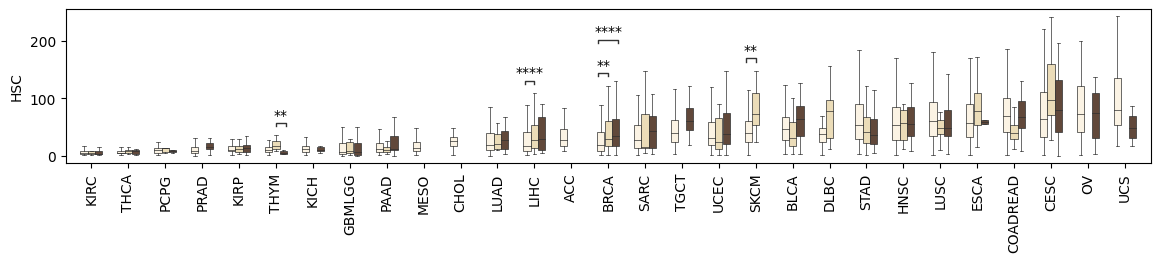

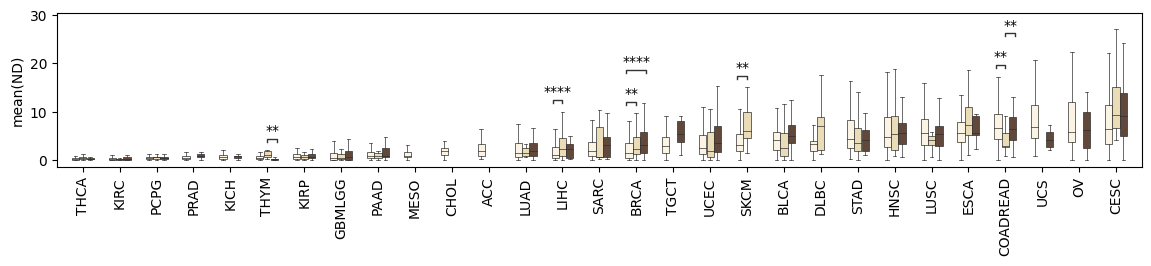

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import featre_to_tick
from statannotations.Annotator import Annotator

# Load the data
data = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer_withAtypical.csv')

cancer_types_low = ["KIRC", "THCA", "PCPG", "PRAD", "KIRP", "THYM", "KICH", "GBMLGG", "PAAD", "MESO", "CHOL", "LUAD", "LIHC", "ACC"]
cancer_types_high = ["BRCA", "SARC", "TGCT", "UCEC", "SKCM", "BLCA", "DLBC", "STAD", "HNSC", "LUSC", "ESCA", "COADREAD", "CESC", "OV", "UCS"]
cancer_types_all = cancer_types_low+cancer_types_high
# Define feature(s) of interest
features_list = ["HSC", "mean(ND)"]  # Replace with your desired features

# Filter the dataframe to include relevant columns and remove invalid cancer types
data = data[data['type'].isin(cancer_types_all)]

# Combine specific cancer types for meaningful grouping
data['type'] = data['type'].replace(['COAD', 'READ'], 'COADREAD')
data['type'] = data['type'].replace(['GBM', 'LGG'], 'GBMLGG')

# Map and filter race data
valid_races = ['WHITE', 'BLACK OR AFRICAN AMERICAN', 'ASIAN', 
               'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
               'AMERICAN INDIAN OR ALASKA NATIVE']

race_short_map = {
    'WHITE': 'White',
    'BLACK OR AFRICAN AMERICAN': 'Black',
    'ASIAN': 'Asian',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Pacific Islander',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'Native American'
}

data = data[data['race'].isin(valid_races)]
data['race'] = data['race'].map(race_short_map)

# Define color palette for races
race_colors = {
    'White': np.array((255, 244, 224)) / 255,
    'Black': np.array((103, 70, 52)) / 255, # np.array((61, 40, 30)) / 255,
    'Asian': np.array((244, 224, 175)) / 255,
    'Pacific Islander': np.array((198, 155, 123)) / 255,
    'Native American': np.array((127, 64, 52)) / 255,
}

# Filter races with less than 5 rows for each cancer type
counts = data.groupby(['type', 'race']).size().reset_index(name='counts')
data = data.merge(counts, on=['type', 'race'])
data = data[data['counts'] >= 5]

# Plot the data for each feature
for feature in features_list:
    # Compute mean feature values for each cancer type and sort them
    mean_feature_by_type = data.groupby('type')[feature].mean()
    sorted_cancer_types = mean_feature_by_type.sort_values().index.tolist()
    
    plt.figure(figsize=(14, 2))

    hue_plot_params = {
        'data':      data,
        'x':         'type',
        'y':         feature,
        "order":     sorted_cancer_types,
        "hue":       "race",
        "hue_order": ["White", "Asian", "Black"],
        "palette":   race_colors,
    }
    
    ax = sns.boxplot(**hue_plot_params,
                     showfliers=False,
                     linewidth=0.5,
                     width = 0.6,

                     )
    plt.legend([],[], frameon=False)
    # Customize the plot
    plt.xlabel('', fontsize=12)
    plt.ylabel(featre_to_tick(feature))
    # plt.title(f'Cancers with relatively higher mitotic activity')
    plt.xticks(rotation=90)

    # Annotating with p-values
    pairs = []
    for c_type in data["type"].unique():
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "White")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Asian")]) > 0:
            pairs.append([(c_type, "White"), (c_type, "Asian")])
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "Black")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Asian")]) > 0:
            pairs.append([(c_type, "Asian"), (c_type, "Black")])
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "White")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Black")]) > 0:
            pairs.append([(c_type, "White"), (c_type, "Black")])

    # Perform the statistical test
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False, line_width=1, hide_non_significant=True, comparisons_correction="fdr_bh")
    results = annotator.apply_and_annotate()
    
    # Display the plot
    # plt.tight_layout()
    plt.savefig(f"results_final_all/landscape/race_dist_{feature}_all.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
    plt.show()



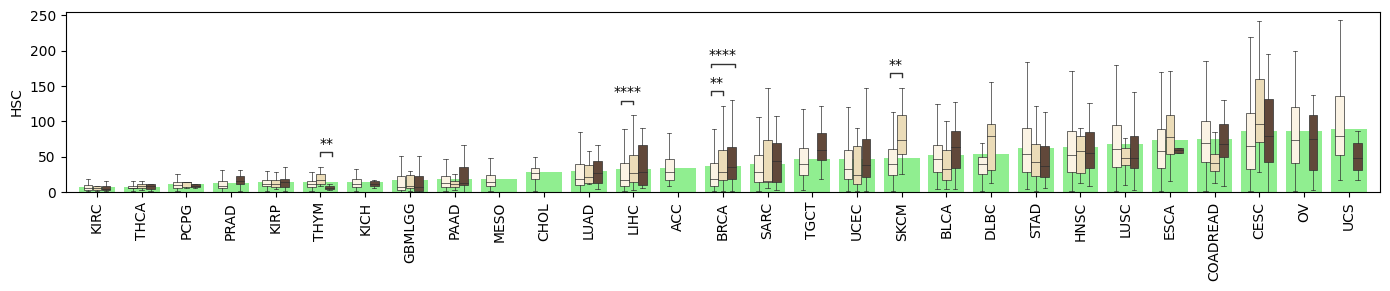

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import featre_to_tick, get_colors_dict
from statannotations.Annotator import Annotator

# Load the data
data = pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer_withAtypical.csv')

cancer_types_low = ["KIRC", "THCA", "PCPG", "PRAD", "KIRP", "THYM", "KICH", "GBMLGG", "PAAD", "MESO", "CHOL", "LUAD", "LIHC", "ACC"]
cancer_types_high = ["BRCA", "SARC", "TGCT", "UCEC", "SKCM", "BLCA", "DLBC", "STAD", "HNSC", "LUSC", "ESCA", "COADREAD", "CESC", "OV", "UCS"]
cancer_types_all = cancer_types_low + cancer_types_high

# Define feature(s) of interest
features_list = ["HSC"]

# Filter the dataframe to include relevant columns and remove invalid cancer types
data = data[data['type'].isin(cancer_types_all)]

# Combine specific cancer types for meaningful grouping
data['type'] = data['type'].replace(['COAD', 'READ'], 'COADREAD')
data['type'] = data['type'].replace(['GBM', 'LGG'], 'GBMLGG')

# Map and filter race data
valid_races = ['WHITE', 'BLACK OR AFRICAN AMERICAN', 'ASIAN', 
               'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
               'AMERICAN INDIAN OR ALASKA NATIVE']

race_short_map = {
    'WHITE': 'White',
    'BLACK OR AFRICAN AMERICAN': 'Black',
    'ASIAN': 'Asian',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Pacific Islander',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'Native American'
}

data = data[data['race'].isin(valid_races)]
data['race'] = data['race'].map(race_short_map)

# Define color palette for races
race_colors = {
    'White': np.array((255, 244, 224)) / 255,
    'Black': np.array((103, 70, 52)) / 255,
    'Asian': np.array((244, 224, 175)) / 255,
    'Pacific Islander': np.array((198, 155, 123)) / 255,
    'Native American': np.array((127, 64, 52)) / 255,
}

# Filter races with less than 5 rows for each cancer type
counts = data.groupby(['type', 'race']).size().reset_index(name='counts')
data = data.merge(counts, on=['type', 'race'])
data = data[data['counts'] >= 5]

# Plot the data for each feature
for feature in features_list:
    # Compute mean feature values for each cancer type and sort them
    mean_feature_by_type = data.groupby('type')[feature].mean()
    sorted_cancer_types = mean_feature_by_type.sort_values().index.tolist()
    
    plt.figure(figsize=(14, 3))
    
    # Create a bar plot in the background
    ax = plt.gca()
    x_positions = range(len(sorted_cancer_types))
    bar_heights = mean_feature_by_type[sorted_cancer_types]
    color_pallete = get_colors_dict()
    cancer_colors = [color_pallete[cancer] for cancer in sorted_cancer_types]
    ax.bar(
        x_positions,
        bar_heights,
        color='lightgreen',
        alpha=1.0,
        width=0.8,
        zorder=0,
        align='center'
    )
    
    # Adjust the x-axis to match cancer type labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sorted_cancer_types, rotation=90)

    # Add the boxplot
    hue_plot_params = {
        'data':      data,
        'x':         'type',
        'y':         feature,
        "order":     sorted_cancer_types,
        "hue":       "race",
        "hue_order": ["White", "Asian", "Black"],
        "palette":   race_colors,
    }
    
    sns.boxplot(**hue_plot_params,
                showfliers=False,
                linewidth=0.5,
                width=0.6,
                zorder=1,  # Place boxplots on top of the bars
                ax=ax)

    # Customize the plot
    plt.xlabel('', fontsize=12)
    plt.ylabel(featre_to_tick(feature))
    plt.legend([], [], frameon=False)

    # Annotating with p-values
    pairs = []
    for c_type in data["type"].unique():
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "White")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Asian")]) > 0:
            pairs.append([(c_type, "White"), (c_type, "Asian")])
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "Black")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Asian")]) > 0:
            pairs.append([(c_type, "Asian"), (c_type, "Black")])
        if len(data.loc[(data["type"] == c_type) & (data["race"] == "White")]) > 0 and len(data.loc[(data["type"] == c_type) & (data["race"] == "Black")]) > 0:
            pairs.append([(c_type, "White"), (c_type, "Black")])

    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False, line_width=1, hide_non_significant=True, comparisons_correction="fdr_bh")
    annotator.apply_and_annotate()
    
    # Save and display the plot
    plt.tight_layout()
    plt.savefig(f"results_final_all/landscape/race_dist_{feature}_all.png", dpi=600, bbox_inches='tight', pad_inches=0.01)
    plt.show()
